In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import chess
import chess.svg
import chess.uci
from tqdm import tqdm

In [2]:
jogo = "1"

array_geral = np.load("Jogos/{}/array_geral_{}.npy".format(jogo, jogo))
array_jogadas = np.load("Jogos/{}/array_jogadas_{}.npy".format(jogo, jogo))

In [3]:
def jogo_ate_i(array_de_jogadas, i = 9999):
    board = chess.Board()
    for jogada in array_de_jogadas[:i]:
        board.push_uci(jogada)
    return board

def converte_notacao_xadrez_afonso(square_number):
    return (63 - square_number)//8, 7 - (63 - square_number)%8

def generate_matrix_board(array_jogadas, i):
    board = jogo_ate_i(array_jogadas, i)
    tabuleiro = np.array([(converte_notacao_xadrez_afonso(i), x.symbol()) for i, x in board.piece_map().items()])
    matrix = np.chararray((8, 8))
    matrix[:] = "_"

    for i, x in tabuleiro:
        matrix[i[0], i[1]] = x
    return matrix

def detect_move(array_jogadas, i):
    prev = generate_matrix_board(array_jogadas, i = i)
    curr = generate_matrix_board(array_jogadas, i = i+1)
    
    np.nonzero(prev != curr)
    return np.transpose(np.argwhere(prev != curr)), prev, curr

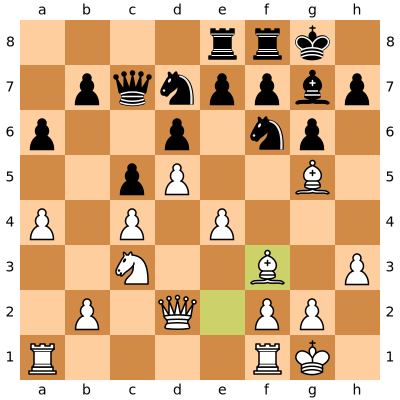

In [4]:
jogo_ate_i(array_jogadas, 25)

In [5]:
def convencional2afonso(string):
    return (8 - int(string[1]), ord(string[0]) - ord("a"))

In [6]:
array_jogadas

array(['d2d4', 'g8f6', 'c2c4', 'g7g6', 'b1c3', 'f8g7', 'e2e4', 'd7d6',
       'g1f3', 'e8g8', 'f1e2', 'c7c5', 'e1g1', 'c8g4', 'd4d5', 'b8d7',
       'c1g5', 'a7a6', 'a2a4', 'd8c7', 'd1d2', 'a8e8', 'h2h3', 'g4f3',
       'e2f3', 'e7e6', 'b2b3', 'g8h8', 'g5e3', 'f6g8', 'f3e2', 'e6e5',
       'g2g4', 'c7d8', 'g1g2', 'd8h4', 'f2f3', 'g7h6', 'g4g5', 'h6g7',
       'e3f2', 'h4f4', 'f2e3', 'f4h4', 'd2e1', 'h4e1', 'f1e1', 'h7h6'],
      dtype='<U4')

In [7]:
jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])

In [8]:
def paint_perspective(array_jogadas, jogada):
    jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])
    img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)

    img_r = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))
    aux = np.zeros((400, 400), dtype = np.float32)
    pts_aux = np.float32([[0,0],[aux.shape[1], 0],[aux.shape[1],aux.shape[0]],[0,aux.shape[0]]])
    
    #jogo 0 e 1
    #pts1 = np.array([[481., 156.], [852., 158.], [852., 522.], [478., 523.]], dtype = np.float32)
    pts1 = np.array([[ 49.,  71.],[282.,  73.],[280., 302.],[ 49., 301.]], dtype = np.float32)
    

    M = cv2.getPerspectiveTransform(pts1, pts_aux)
    perspectiva = cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT)
    
    if jogada == 0:
        return perspectiva
    
    j, i = jogadas_pos[jogada-1][0]
    perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
    (perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (255, 0, 0), 3)

    j, i = jogadas_pos[jogada-1][1]
    perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
    (perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (0, 255, 0), 3)
    
    return perspectiva

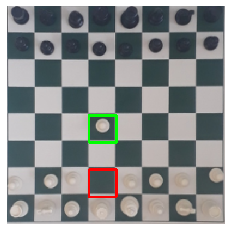

In [12]:
plt.axis("off")
plt.imshow(paint_perspective(array_jogadas, 1))

In [10]:
engine = chess.uci.popen_engine("stockfish")
engine.uci()
info_handler = chess.uci.InfoHandler()
engine.info_handlers.append(info_handler)

lst_evals = [(0, None)]
with tqdm(total = len(array_jogadas)) as pbar:
    for i in range(len(array_jogadas)):
        board = jogo_ate_i(array_jogadas, i)
        engine.position(board)
        engine.go(movetime = 1000)
        #print(i)
        print(info_handler.info["score"][1])
        lst_evals.append((info_handler.info["score"][1].cp, info_handler.info["score"][1].mate))
        pbar.update(1)

  2%|▏         | 1/48 [00:01<00:47,  1.01s/it]

Score(cp=25, mate=None)


  4%|▍         | 2/48 [00:02<00:46,  1.01s/it]

Score(cp=-30, mate=None)


  6%|▋         | 3/48 [00:03<00:45,  1.01s/it]

Score(cp=14, mate=None)


  8%|▊         | 4/48 [00:04<00:44,  1.01s/it]

Score(cp=-20, mate=None)


 10%|█         | 5/48 [00:05<00:43,  1.00s/it]

Score(cp=54, mate=None)


 12%|█▎        | 6/48 [00:06<00:42,  1.00s/it]

Score(cp=-56, mate=None)


 15%|█▍        | 7/48 [00:07<00:41,  1.00s/it]

Score(cp=61, mate=None)


 17%|█▋        | 8/48 [00:08<00:40,  1.01s/it]

Score(cp=-59, mate=None)


 19%|█▉        | 9/48 [00:09<00:39,  1.01s/it]

Score(cp=52, mate=None)


 21%|██        | 10/48 [00:10<00:38,  1.00s/it]

Score(cp=-44, mate=None)


 23%|██▎       | 11/48 [00:11<00:37,  1.01s/it]

Score(cp=45, mate=None)


 25%|██▌       | 12/48 [00:12<00:36,  1.01s/it]

Score(cp=-48, mate=None)


 27%|██▋       | 13/48 [00:13<00:35,  1.01s/it]

Score(cp=76, mate=None)


 29%|██▉       | 14/48 [00:14<00:34,  1.01s/it]

Score(cp=-61, mate=None)


 31%|███▏      | 15/48 [00:15<00:33,  1.01s/it]

Score(cp=85, mate=None)


 33%|███▎      | 16/48 [00:16<00:32,  1.01s/it]

Score(cp=-81, mate=None)


 35%|███▌      | 17/48 [00:17<00:31,  1.01s/it]

Score(cp=79, mate=None)


 38%|███▊      | 18/48 [00:18<00:30,  1.01s/it]

Score(cp=-68, mate=None)


KeyboardInterrupt: 

In [ ]:
lst_evals

In [ ]:
for i, x in enumerate(lst_evals):
    if isinstance(x[0], int):
        if i % 2 == 0:
            print(-x[0])
        else:
            print(x[0])

In [ ]:
fig, axs = plt.subplots(10, 5, figsize = (16, 30))
[ax.set_axis_off() for ax in axs.ravel()]
#fig.set_facecolor("white")

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ind_1d = i*axs.shape[1]+j
        if ind_1d > len(array_jogadas):
            axs[i, j].imshow(np.zeros((400, 400)))
        else:
            axs[i, j].set_title("Score: {}".format(lst_evals[ind_1d][0] if ind_1d % 2 == 1 else -lst_evals[ind_1d][0]))
            axs[i, j].imshow(paint_perspective(array_jogadas, ind_1d))

In [ ]:
#fig.savefig("ReadMe_Images/geral_jogo1.png", dpi = 60)

In [ ]:
jogada = 10
img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.imshow(img)

In [ ]:
jogada = 1
jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])
img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)

img_r = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))
aux = np.zeros((400, 400), dtype = np.float32)
pts_aux = np.float32([[0,0],[aux.shape[1], 0],[aux.shape[1],aux.shape[0]],[0,aux.shape[0]]])

#jogo 0 e 1
#pts1 = np.array([[481., 156.], [852., 158.], [852., 522.], [478., 523.]], dtype = np.float32)
pts1 = np.array([[ 49.,  71.],[282.,  73.],[280., 302.],[ 49., 301.]], dtype = np.float32)


M = cv2.getPerspectiveTransform(pts1, pts_aux)
perspectiva = cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT)

# if jogada == 0:
#     return perspectiva

j, i = jogadas_pos[jogada-1][0]
perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
(perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (255, 0, 0), 3)

j, i = jogadas_pos[jogada-1][1]
perspectiva = cv2.rectangle(perspectiva, (perspectiva.shape[1]*i//8, perspectiva.shape[0]*j//8), \
(perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*(j+1)//8), (0, 255, 0), 3)

In [ ]:
plt.imshow(perspectiva)

In [ ]:
####

In [ ]:
jogada = 48

jogadas_pos = np.array([(convencional2afonso(x[:2]), convencional2afonso(x[2:])) for x in array_jogadas])
img = cv2.cvtColor(cv2.imread("Jogos/{}/{}.jpg".format(jogo, jogada)), cv2.COLOR_BGR2RGB)

pts1 = np.array([[ 49.,  71.],[282.,  73.],[280., 302.],[ 49., 301.]], dtype = np.float32)
pts1 = pts1.astype(np.uint16)


w, h = pts1[2] - pts1[0]
sw, sh = w//8, h//8

img = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))

j, i = jogadas_pos[jogada-1][0]
img = cv2.rectangle(img, (pts1[0][0] + i * sw,  pts1[0][1] + j * sh),   (pts1[0][0] + (i+1) * sw,  pts1[0][1] + (j+1) * sh), (255, 0, 0), 3 )

j, i = jogadas_pos[jogada-1][1]
img = cv2.rectangle(img, (pts1[0][0] + i * sw,  pts1[0][1] + j * sh),   (pts1[0][0] + (i+1) * sw,  pts1[0][1] + (j+1) * sh), (0, 255, 0), 3 )

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.putText(img,'Score: {}'.format(lst_evals[jogada][0]), (0, img.shape[0] - 10), font, 0.7,(0, 0 ,255), 2, cv2.LINE_AA)

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(img)